#Import

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
# import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


#Build Network

In [ ]:
delta = 1

class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return  x* self.sigmoid(x)

activation = nn.GELU()
activation_ = torch.tanh

In [ ]:
M = 50
selu = Swish()

T = True
F = False

class Net_2D(nn.Module):
    def __init__(self):
        super(Net_2D, self).__init__()
        torch.manual_seed(1234) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(2,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer2 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer3 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer4 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.output_layer = nn.Linear(M,2, bias = T)

    def forward(self, x,y):
        inputs = torch.cat([x,y],axis=1)
        layer1_out = activation(self.hidden_layer1(inputs))
        layer2_out = activation(self.hidden_layer2(layer1_out))
        layer3_out = activation(self.hidden_layer3(layer2_out))
        layer4_out = activation(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)

        return output

class Net_2D_f(nn.Module):
    def __init__(self):
        super(Net_2D_f, self).__init__()
        torch.manual_seed(1234) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(2,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer2 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer3 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer4 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.output_layer = nn.Linear(M,2, bias = T)

    def forward(self, x,y):
        inputs = torch.cat([x,y],axis=1)
        layer1_out = activation_(self.hidden_layer1(inputs))
        layer2_out = activation_(self.hidden_layer2(layer1_out))
        layer3_out = activation_(self.hidden_layer3(layer2_out))
        layer4_out = activation_(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)

        return output

#loss,optimize

In [ ]:
import torch
import torch.nn.init as init

### (2) Model
mse_cost_function = torch.nn.MSELoss() #MSE Function can be shared

net_2d_1 = Net_2D()
net_2d_1 = net_2d_1.to(device)

net_2d_2 = Net_2D()
net_2d_2= net_2d_2.to(device)

net_2d_f = Net_2D_f()
net_2d_f= net_2d_f.to(device)

net_2d_f0 = Net_2D_f()
net_2d_f0= net_2d_f0.to(device)

optimizer1 = torch.optim.Adam(net_2d_1.parameters(),lr=0.001)
optimizer2 = torch.optim.Adam(net_2d_2.parameters(),lr=0.001)
optimizerf = torch.optim.Adam(net_2d_f.parameters(),lr=0.001)
optimizerf0 = torch.optim.Adam(net_2d_f0.parameters(),lr=0.001)

#set PDE,residual
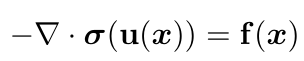

In [ ]:
N = 1
C = 0.05
lamb = 10000
mu = 1

#/ 10,0.1 / 100,0.05 / 1000,0.05 / 10000,0.05 / 100000,0.05 / 1000000,0.001

def f(x,y,x_bd,y_bd, net1, net2, net3, net4, epoch):
    f1 = -((lamb+1)/lamb)*torch.cos((x+y)/N) + 8*torch.cos(2*x/N)*torch.sin(2*y/N) + (2/lamb)*torch.sin(x/N)*torch.sin(y/N) - 4*torch.sin(2*y/N)
    f2 = -((lamb+1)/lamb)*torch.cos((x+y)/N) - 8*torch.cos(2*y/N)*torch.sin(2*x/N) + (2/lamb)*torch.sin(x/N)*torch.sin(y/N) + 4*torch.sin(2*x/N)

    w1 = net1(x,y)[:, 0:1]
    v1 = net1(x,y)[:, 1:2] #u_tilda

    w2 = net2(x,y)[:, 0:1]
    v2 = net2(x,y)[:, 1:2] #u_hat

    net_f1 = net3(x,y)[:, 0:1]
    net_f2 = net3(x,y)[:, 1:2] #f_hat

    net_f1_0 = net4(x,y)[:, 0:1]
    net_f2_0 = net4(x,y)[:, 1:2] #f_0

    w1_bdy = net1(x_bd,y_bd)[:, 0:1]
    v1_bdy = net1(x_bd,y_bd)[:, 1:2]

    w2_bdy = net2(x_bd,y_bd)[:, 0:1]
    v2_bdy = net2(x_bd,y_bd)[:, 1:2]

    w1_x = torch.autograd.grad(w1.sum(), x, create_graph=True)[0]
    w1_y = torch.autograd.grad(w1.sum(), y, create_graph=True)[0]
    w1_xx = torch.autograd.grad(w1_x.sum(), x, create_graph=True)[0]
    w1_yy = torch.autograd.grad(w1_y.sum(), y, create_graph=True)[0]
    w1_xy = torch.autograd.grad(w1_x.sum(), y, create_graph=True)[0]

    v1_x = torch.autograd.grad(v1.sum(), x, create_graph=True)[0]
    v1_y = torch.autograd.grad(v1.sum(), y, create_graph=True)[0]
    v1_xx = torch.autograd.grad(v1_x.sum(), x, create_graph=True)[0]
    v1_yy = torch.autograd.grad(v1_y.sum(), y, create_graph=True)[0]
    v1_xy = torch.autograd.grad(v1_x.sum(), y, create_graph=True)[0]

    w2_x = torch.autograd.grad(w2.sum(), x, create_graph=True)[0]
    w2_y = torch.autograd.grad(w2.sum(), y, create_graph=True)[0]
    w2_xx = torch.autograd.grad(w2_x.sum(), x, create_graph=True)[0]
    w2_yy = torch.autograd.grad(w2_y.sum(), y, create_graph=True)[0]
    w2_xy = torch.autograd.grad(w2_x.sum(), y, create_graph=True)[0]

    v2_x = torch.autograd.grad(v2.sum(), x, create_graph=True)[0]
    v2_y = torch.autograd.grad(v2.sum(), y, create_graph=True)[0]
    v2_xx = torch.autograd.grad(v2_x.sum(), x, create_graph=True)[0]
    v2_yy = torch.autograd.grad(v2_y.sum(), y, create_graph=True)[0]
    v2_xy = torch.autograd.grad(v2_x.sum(), y, create_graph=True)[0]

    u1_dual_r1 = ((-2*mu*N*N*(w1_xx + 0.5*(v1_xy+w1_yy)) - net_f1_0) **2).mean()
    u1_dual_r2 = ((-2*mu*N*N*(v1_yy + 0.5*(v1_xx+w1_xy)) - net_f2_0)**2).mean()
    u1_r1 = ((-(lamb*N*N)*(w1_xx+v1_xy) - net_f1)**2).mean()
    u1_r2 = ((-(lamb*N*N)*(w1_xy+v1_yy) - net_f2)**2).mean()


    u2_dual_r1 = ((-(1*N*N)*(w2_xx+v2_xy))**2).mean()
    u2_dual_r2 = ((-(1*N*N)*(w2_xy+v2_yy))**2).mean()
    u2_r1 = ((-2*mu*N*N*(w2_xx + 0.5*(v2_xy+w2_yy)) - f1 + net_f1 + net_f1_0)**2).mean()
    u2_r2 = ((-2*mu*N*N*(v2_yy + 0.5*(v2_xx+w2_xy)) - f2 + net_f2 + net_f2_0)**2).mean()

    bdy1_loss = ((w1_bdy + w2_bdy)**2).mean()
    bdy2_loss = ((v1_bdy + v2_bdy)**2).mean()

    MSE_f_loss = ((net_f1**2 + net_f2**2).mean())

    return (u1_dual_r1 + u1_dual_r2 + C*u1_r1 + C*u1_r2 + u2_dual_r1 + u2_dual_r2 + u2_r1 + u2_r2) + 10*bdy1_loss + 10*bdy2_loss

def f_1(x,y,x_bd,y_bd, net1, epoch):
    f1 = -((lamb+1)/lamb)*torch.cos(x/N+y/N) + 8*torch.cos(2*x/N)*torch.sin(2*y/N) + (2/lamb)*torch.sin(x/N)*torch.sin(y/N) - 4*torch.sin(2*y/N)
    f2 = -((lamb+1)/lamb)*torch.cos(x/N+y/N) - 8*torch.cos(2*y/N)*torch.sin(2*x/N) + (2/lamb)*torch.sin(x/N)*torch.sin(y/N) + 4*torch.sin(2*x/N)

    w1 = net1(x,y)[:, 0:1]
    v1 = net1(x,y)[:, 1:2] #u_tilda

    w1_bdy = net1(x_bd,y_bd)[:, 0:1]
    v1_bdy = net1(x_bd,y_bd)[:, 1:2]

    w1_x = torch.autograd.grad(w1.sum(), x, create_graph=True)[0]
    w1_y = torch.autograd.grad(w1.sum(), y, create_graph=True)[0]
    w1_xx = torch.autograd.grad(w1_x.sum(), x, create_graph=True)[0]
    w1_yy = torch.autograd.grad(w1_y.sum(), y, create_graph=True)[0]
    w1_xy = torch.autograd.grad(w1_x.sum(), y, create_graph=True)[0]

    v1_x = torch.autograd.grad(v1.sum(), x, create_graph=True)[0]
    v1_y = torch.autograd.grad(v1.sum(), y, create_graph=True)[0]
    v1_xx = torch.autograd.grad(v1_x.sum(), x, create_graph=True)[0]
    v1_yy = torch.autograd.grad(v1_y.sum(), y, create_graph=True)[0]
    v1_xy = torch.autograd.grad(v1_x.sum(), y, create_graph=True)[0]

    u_r1 = ((-2*mu*(w1_xx + 0.5*(v1_xy+w1_yy))-(lamb)*(w1_xx+v1_xy) - f1)**2).mean()
    u_r2 = ((-2*mu*(v1_yy + 0.5*(v1_xx+w1_xy))-(lamb)*(w1_xy+v1_yy) - f2)**2).mean()

    bdy1_loss = ((w1_bdy)**2).mean()
    bdy2_loss = ((v1_bdy)**2).mean()

    return C*u_r1 + C*u_r2 + 10*bdy1_loss + 10*bdy2_loss

#Set data point

In [ ]:
x_collocation = np.random.uniform(low = 0 , high = N*np.pi , size=(5000,1))
y_collocation = np.random.uniform(low = 0 , high = N*np.pi , size=(5000,1))

pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True).to(device)

In [ ]:
##----------------------------------------boundary-------------------------------------------#$
x = np.linspace(0, N*np.pi, 100)
y = np.linspace(0, N*np.pi, 100)

#
bottom_edge = np.column_stack((x, np.zeros_like(x)))  # y = 0, x는 [0, pi]
top_edge = np.column_stack((x, np.full_like(x, N*np.pi)))  # y = pi, x는 [0, pi]
left_edge = np.column_stack((np.zeros_like(y), y))  # x = 0, y는 [0, pi]
right_edge = np.column_stack((np.full_like(y, N*np.pi), y))  # x = pi, y는 [0, pi]

#
boundary_points = np.vstack((bottom_edge, top_edge, left_edge, right_edge))

#
print("Total boundary points:", boundary_points.shape[0])
# print(boundary_points)

x_coords = boundary_points[:, 0].reshape(-1, 1)  # x 좌표 (400, 1)
y_coords = boundary_points[:, 1].reshape(-1, 1)  # y 좌표 (400, 1)

bdy_x_collocation = Variable(torch.from_numpy(x_coords).float(), requires_grad=True).to(device)
bdy_y_collocation = Variable(torch.from_numpy(y_coords).float(), requires_grad=True).to(device)

Total boundary points: 400


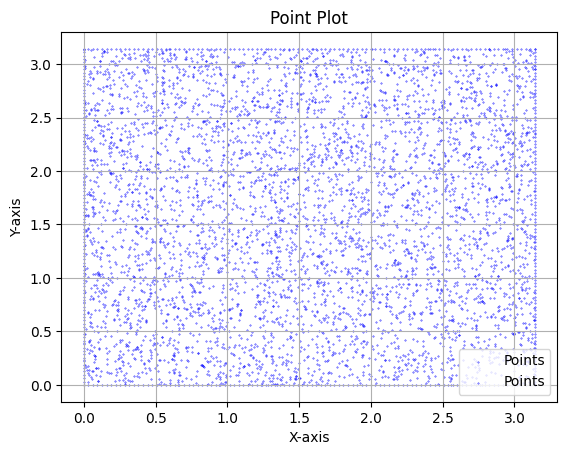

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

plt.scatter(x_collocation, y_collocation, color='blue', marker='o', label='Points',s=0.1)

plt.scatter(x_coords, y_coords, color='blue', marker='o', label='Points',s=0.1)


plt.title("Point Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

#
plt.legend()

#
plt.grid(True)
plt.show()

# Learn F

In [ ]:
f_x_col = Variable(torch.from_numpy(x_collocation).float(), requires_grad=False).to(device)
f_y_col = Variable(torch.from_numpy(y_collocation).float(), requires_grad=False).to(device)

label_f1 = -((lamb+1)/lamb)*torch.cos(f_x_col/N + f_y_col/N) + 8*torch.cos(2*f_x_col/N)*torch.sin(2*f_y_col/N) + (2/lamb)*torch.sin(f_x_col/N)*torch.sin(f_y_col/N) - 4*torch.sin(2*f_y_col/N)
label_f2 = -((lamb+1)/lamb)*torch.cos(f_x_col/N + f_y_col/N) - 8*torch.cos(2*f_y_col/N)*torch.sin(2*f_x_col/N) + (2/lamb)*torch.sin(f_x_col/N)*torch.sin(f_y_col/N) + 4*torch.sin(2*f_x_col/N)

In [ ]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0

while epoch < 2000:
    optimizerf.zero_grad()

##------------------------------------Compute Loss-----------------------------------------##

    pred_f_1 = net_2d_f(pt_x_collocation, pt_y_collocation)[:, 0:1]
    pred_f_2 = net_2d_f(pt_x_collocation, pt_y_collocation)[:, 1:2]
    msef_1 = mse_cost_function(pred_f_1, (1)*label_f1)
    msef_2 = mse_cost_function(pred_f_2, (1)*label_f2) # 앞에 상수는 일부로 0.5로 두긴 했습니다

    loss_f = 0.1*(msef_1 + msef_2)

##------------------------------------Optimize Loss-----------------------------------------##

    loss_f.backward()
    optimizerf.step()

    epoch += 1

    if epoch % 100 == 1:
        print("MSE Error: ", loss_f.item())

MSE Error:  4.798831939697266
MSE Error:  2.0651493072509766
MSE Error:  1.7769348621368408
MSE Error:  0.4595678448677063
MSE Error:  0.03849056363105774
MSE Error:  0.013333642855286598
MSE Error:  0.008523833006620407
MSE Error:  0.006441538687795401
MSE Error:  0.005226333625614643
MSE Error:  0.004427268635481596
MSE Error:  0.0038479752838611603
MSE Error:  0.0034072287380695343
MSE Error:  0.0030539892613887787
MSE Error:  0.002765126060694456
MSE Error:  0.0025133860763162374
MSE Error:  0.002301719505339861
MSE Error:  0.0021028928458690643
MSE Error:  0.002079147147014737
MSE Error:  0.0017699893796816468
MSE Error:  0.0016230259789153934


In [ ]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0

while epoch < 2000:
    optimizerf0.zero_grad()

##------------------------------------Compute Loss-----------------------------------------##

    pred_f_10 = net_2d_f0(pt_x_collocation, pt_y_collocation)[:, 0:1]
    pred_f_20 = net_2d_f0(pt_x_collocation, pt_y_collocation)[:, 1:2]
    msef_10 = mse_cost_function(pred_f_10, (1)*label_f1)
    msef_20 = mse_cost_function(pred_f_20, (1)*label_f2) # 앞에 상수는 일부로 0.5로 두긴 했습니다

    loss_f0 = 0.1*(msef_10 + msef_20)

##------------------------------------Optimize Loss-----------------------------------------##

    loss_f0.backward()
    optimizerf0.step()

    epoch += 1

    if epoch % 100 == 1:
        print("MSE Error: ", loss_f0.item())

MSE Error:  4.798831939697266
MSE Error:  2.0651493072509766
MSE Error:  1.7769348621368408
MSE Error:  0.4595678448677063
MSE Error:  0.03849056363105774
MSE Error:  0.013333642855286598
MSE Error:  0.008523833006620407
MSE Error:  0.006441538687795401
MSE Error:  0.005226333625614643
MSE Error:  0.004427268635481596
MSE Error:  0.0038479752838611603
MSE Error:  0.0034072287380695343
MSE Error:  0.0030539892613887787
MSE Error:  0.002765126060694456
MSE Error:  0.0025133860763162374
MSE Error:  0.002301719505339861
MSE Error:  0.0021028928458690643
MSE Error:  0.002079147147014737
MSE Error:  0.0017699893796816468
MSE Error:  0.0016230259789153934


#Observe Points

In [ ]:
x_ = np.arange(0,np.pi,0.1)
y_ = np.arange(0,np.pi,0.1)

ms_x_ , ms_y_= np.meshgrid(x_,y_)

x_ = np.ravel(ms_x_).reshape(-1,1)
y_ = np.ravel(ms_y_).reshape(-1,1)

pt_x_ = Variable(torch.from_numpy(x_).float(), requires_grad=False).to(device)
pt_y_ = Variable(torch.from_numpy(y_).float(), requires_grad=False).to(device)

In [ ]:
Iterlist = []
Loss = []
Error_stan = []
Error_decom = []
Error_decom_vs = []
Error_decom_vs1 = []
Error_decom_vs2 = []

#Train

In [ ]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0

while epoch < 50000:
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizerf.zero_grad()
    optimizerf0.zero_grad()
##------------------------------------Compute Loss-----------------------------------------##

    loss = 1*f(pt_x_collocation, pt_y_collocation, bdy_x_collocation, bdy_y_collocation, net_2d_1, net_2d_2, net_2d_f, net_2d_f0, epoch)
    # loss = 1*f_1(pt_x_collocation, pt_y_collocation, bdy_x_collocation, bdy_y_collocation, net_2d_1, epoch)

##------------------------------------Optimize Loss-----------------------------------------##

    loss.backward()
    optimizer1.step()
    optimizer2.step()
    optimizerf.step()
    optimizerf0.step()

    epoch += 1
##----------------------------Result-----------------------------##

    if (epoch) % 200 == 1:
        gap2 = torch.sqrt((((((net_2d_1(N*pt_x_,N*pt_y_)+net_2d_2(N*pt_x_,N*pt_y_))[:,1:2]) - (1-torch.cos(2*pt_y_))*torch.sin(2*pt_x_) - torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean())/((((1-torch.cos(2*pt_y_))*torch.sin(2*pt_x_) + torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean()))
        gap1 = torch.sqrt((((((net_2d_1(N*pt_x_,N*pt_y_)+net_2d_2(N*pt_x_,N*pt_y_))[:,0:1]) - (torch.cos(2*pt_x_)-1)*torch.sin(2*pt_y_) - torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean())/((((torch.cos(2*pt_x_)-1)*torch.sin(2*pt_y_) + torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean()))

        # gap2 = torch.sqrt((((((net_2d_1(N*pt_x_,N*pt_y_))[:,1:2]) - (1-torch.cos(2*pt_y_))*torch.sin(2*pt_x_) - torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean())/((((1-torch.cos(2*pt_y_))*torch.sin(2*pt_x_) + torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean()))
        # gap1 = torch.sqrt((((((net_2d_1(N*pt_x_,N*pt_y_))[:,0:1]) - (torch.cos(2*pt_x_)-1)*torch.sin(2*pt_y_) - torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean())/((((torch.cos(2*pt_x_)-1)*torch.sin(2*pt_y_) + torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean()))

        Iterlist.append(epoch)
        Error_decom.append(0.5*(gap1+gap2).cpu().detach().numpy())
        # Error_stan.append(0.5*(gap1+gap2).cpu().detach().numpy())
        # Error_decom_vs.append(0.5*(gap1+gap2).cpu().detach().numpy())
        # Loss.append(loss.item())


    if (epoch) % 200 == 1:
        print("-----------------------------------------------------------------------------")
        print("Epoch:",epoch)
        # print("Lambda PDE Loss :", (mse1_r1 + mse1_r2).item())
        # print("Mu PDE Loss :", (mse2_r1 + mse2_r2).item())
        print("Loss :", (loss).item())

        print((gap2+gap1)*0.5)

-----------------------------------------------------------------------------
Epoch: 1
Loss : 117.04875183105469
tensor(1.0067, device='cuda:0', grad_fn=<MulBackward0>)
-----------------------------------------------------------------------------
Epoch: 201
Loss : 1.832475185394287
tensor(0.9202, device='cuda:0', grad_fn=<MulBackward0>)
-----------------------------------------------------------------------------
Epoch: 401
Loss : 0.12862034142017365
tensor(0.1464, device='cuda:0', grad_fn=<MulBackward0>)
-----------------------------------------------------------------------------
Epoch: 601
Loss : 0.049418527632951736
tensor(0.0603, device='cuda:0', grad_fn=<MulBackward0>)
-----------------------------------------------------------------------------
Epoch: 801
Loss : 0.03216180205345154
tensor(0.0467, device='cuda:0', grad_fn=<MulBackward0>)
-----------------------------------------------------------------------------
Epoch: 1001
Loss : 0.02160337194800377
tensor(0.0255, device='cuda

In [ ]:
min(Error_decom)

np.float32(0.0003994417)

#Plotting Prediction

tensor(1.2227, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.1845, device='cuda:0', grad_fn=<MinBackward1>)


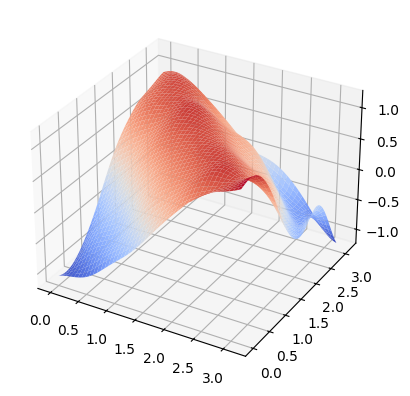

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

x_ = np.arange(0,np.pi,0.01)
y_ = np.arange(0,np.pi,0.01)

ms_x_ , ms_y_= np.meshgrid(x_,y_)

x_ = np.ravel(ms_x_).reshape(-1,1)
y_ = np.ravel(ms_y_).reshape(-1,1)

pt_x_ = Variable(torch.from_numpy(x_).float(), requires_grad=False).to(device)
pt_y_ = Variable(torch.from_numpy(y_).float(), requires_grad=False).to(device)

# pt_u3 = ((net_2d_2(N*pt_x_,N*pt_y_) + net_2d_1(N*pt_x_,N*pt_y_))[:,0:1])

pt_u3 = (net_2d_f(N*pt_x_,N*pt_y_))[:,1]

print(pt_u3.max())
print(pt_u3.min())

u3 = pt_u3.data.cpu().numpy()
ms_u3 = u3.reshape(ms_x_.shape)

surf3 = ax.plot_surface(ms_x_,ms_y_,ms_u3,cmap=cm.coolwarm,linewidth=0, antialiased=True)

# ax.set_zlim(-2, 2)

plt.show()

In [ ]:
gap = torch.sqrt((((((net_2d_1(N*pt_x_,N*pt_y_)+net_2d_2(N*pt_x_,N*pt_y_))[:,1:2]) - (1-torch.cos(2*pt_y_))*torch.sin(2*pt_x_) - torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean())/((((1-torch.cos(2*pt_y_))*torch.sin(2*pt_x_) + torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean()))
print(gap)

tensor(1.0001, device='cuda:0', grad_fn=<SqrtBackward0>)


In [ ]:
gap = torch.sqrt((((((net_2d_1(N*pt_x_,N*pt_y_)+net_2d_2(N*pt_x_,N*pt_y_))[:,0:1]) - (torch.cos(2*pt_x_)-1)*torch.sin(2*pt_y_) - torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean())/((((torch.cos(2*pt_x_)-1)*torch.sin(2*pt_y_) + torch.sin(pt_x_)*torch.sin(pt_y_)/lamb)**2).mean()))
gap

tensor(0.9995, device='cuda:0', grad_fn=<SqrtBackward0>)

#Plot learning curve

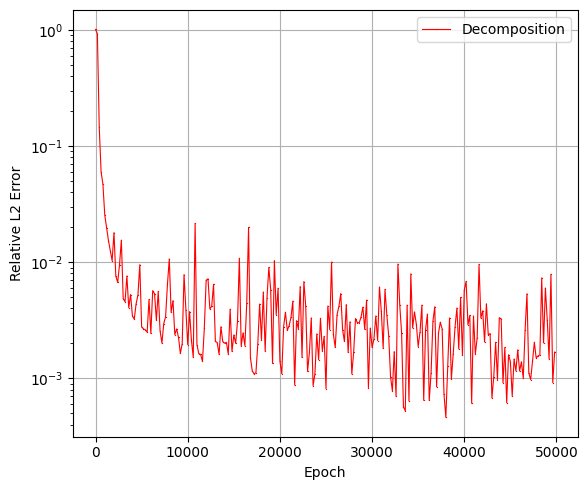

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))


# plt.plot(Iterlist, Error_stan ,color = 'blue', marker='x',markersize=0.3,label='Standard',linewidth = "0.8")
plt.plot(Iterlist, Error_decom ,color = 'red', marker='x',markersize=0.3,label='Decomposition',linewidth = "0.8")


plt.yscale('log')
plt.legend(loc = 'upper right')


plt.xlabel('Epoch')
plt.ylabel('Relative L2 Error')
# plt.title('Learning Curve')
plt.yscale("log")
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()